In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from statsmodels.stats.multitest import multipletests
%load_ext autoreload
%autoreload 2

In [2]:
def compute_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def compute_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def plot_roc_curve(y_true, y_pred, label, ax, sample=False):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    if sample:
        sns.lineplot(fpr[::sample], tpr[::sample], lw=1, ax=ax, alpha=0.3, label="{} - AUC: %0.2f".format(label) % (roc_auc))
    else:
        sns.lineplot(fpr, tpr, lw=1, ax=ax, alpha=0.3, label="{} - AUC: %0.2f".format(label) % (roc_auc), rasterized=False)


def plot_pr_curve(y_true, y_pred, label, ax, sample=False):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    if sample:
        sns.lineplot(recall[::sample], precision[::sample], lw=1, alpha=0.3, ax=ax, label="{} - AUC: %0.2f".format(label) % (pr_auc))
    else:
        sns.lineplot(recall, precision, lw=1, alpha=0.3, ax=ax, label="{} - AUC: %0.2f".format(label) % (pr_auc), 
                     rasterized=False)

def customise_roc_pr_plots(axes, label_size=15, font_size=15, linewidth=5, patch_size=20):
    # Customizing plots
    for ax in axes:
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)

        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(font_size)

        plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))
        plt.setp(ax.lines, linewidth=linewidth)

    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')

    for ax in axes:
        for axis in [ax.xaxis, ax.yaxis]:
            axis.label.set_size(font_size)

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')

    for ax in axes:
        ax.legend(loc='best', prop={'size': patch_size})

In [3]:
from pyensembl import Genome
from multiprocessing import Pool
from tqdm.notebook import tqdm
from itertools import product


def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)

def add_chromosome_info(info_df):
    info_df["chr"] = info_df["gene_id"].apply(lambda x: chr_map[genome.gene_by_id(x).contig])
    return info_df

chrsm_annot_dir = "/mnt/dataHDD/chris/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/mnt/dataHDD/chris/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/mnt/dataHDD/chris/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

gt_dir = "/mnt/data/chris/gt_mapping_final/"

NUM_NEIGHBORING_FEATURES = 1
CENTER_MOTIFS = [['A', 'G', 'T'], ['G', 'A'], ['A'], ['C'], ['A', 'C', 'T']]
ALL_KMERS = list(["".join(x) for x in product(*(CENTER_MOTIFS))])

In [4]:
if not os.path.exists("./Figure_2"):
    os.mkdir("./Figure_2")

In [5]:
model_results = "/mnt/data/chris/comparison/"
df = []

df = None
for model in ['prod_pooling']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        result = add_chromosome_and_gene_info(result)
        result = add_genomic_position(result)

        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))

        result = pd.merge(result, label, on=["gene_id", "genomic_position",
                                             "transcript_id", "transcript_position"])
        result = result[["gene_id", "genomic_position", "transcript_id", "transcript_position", 
                        "probability_modified", "modification_status"]]
        result = add_genomic_position(result)
        result = add_chromosome_info(result)
        result = result.rename({'probability_modified': "probability_modified_{}".format(model)}, axis=1)
        result = result.groupby(["gene_id", "genomic_position", "chr", "kmer"]).mean()
        if df is None:
            df = result
        else:
            df = df.merge(result, on=["gene_id", "genomic_position", "chr", "kmer"])


  0%|          | 0/4662 [00:00<?, ?it/s]

  0%|          | 0/4662 [00:00<?, ?it/s]

In [6]:
df

transcript_position  \
gene_id         genomic_position chr  kmer                         
ENSG00000000003 100629726        chrX AAACA               1149.0   
                100629744        chrX AAACC               1131.0   
                100629862        chrX AAACT               1013.0   
                100629869        chrX AGACC               1006.0   
                100629907        chrX AAACT                968.0   
...                                                          ...   
ENSG00000284707 97864409         chr7 AAACA               1556.0   
                97864429         chr7 TGACA               1536.0   
                97864466         chr7 AGACC               1499.0   
                97868996         chr7 TGACC               1380.0   
                97872366         chr7 TGACC               1145.0   

                                             probability_modified_prod_pooling  \
gene_id         genomic_position chr  kmer                                       
ENSG00000000003 100629726        chrX AAACA                           0.019846   
                100629744        chrX AAACC                           0.007654   
                100629862        chrX AAACT                           0.321211   
                100629869        chrX AGACC                           0.135096   
                100629907        chrX AAACT                           0.008265   
...                                                                        ...   
ENSG00000284707 97864409         chr7 AAACA                           0.030498   
                97864429         chr7 TGACA                           0.070821   
                97864466         chr7 AGACC                           0.121067   
                97868996         chr7 TGACC                           0.176175   
                97872366         chr7 TGACC                           0.272538   

                                             modification_status  
gene_id         genomic_position chr  kmer                        
ENSG00000000003 100629726        chrX AAACA                  0.0  
                100629744        chrX AAACC                  0.0  
                100629862        chrX AAACT                  0.0  
                100629869        chrX AGACC                  0.0  
                100629907        chrX AAACT                  0.0  
...                                                          ...  
ENSG00000284707 97864409         chr7 AAACA                  0.0  
                97864429         chr7 TGACA                  0.0  
                97864466         chr7 AGACC                  0.0  
                97868996         chr7 TGACC                  0.0  
                97872366         chr7 TGACC                  0.0  

[75371 rows x 3 columns]

In [9]:
tombo_results_plus = pd.read_csv("/mnt/data/chris/comparison/tombo/hek293t_rep2.fraction_modified_reads.plus.wig.bed", 
                        delimiter="\t", names=["transcript_id", "start", "end", "id", "fraction_modified"])
tombo_results_plus["transcript_id"] = tombo_results_plus["transcript_id"].apply(lambda x: x.split(".")[0])
tombo_results_plus["transcript_position"] = tombo_results_plus["start"] - 1

tombo_results_minus = pd.read_csv("/mnt/data/chris/comparison/tombo/hek293t_rep2.fraction_modified_reads.minus.wig.bed", 
                        delimiter="\t", names=["transcript_id", "start", "end", "id", "fraction_modified"])
tombo_results_minus["transcript_id"] = tombo_results_minus["transcript_id"].apply(lambda x: x.split(".")[0])
tombo_results_minus["transcript_position"] = tombo_results_minus["start"] - 1

tombo_results = pd.concat([tombo_results_plus, tombo_results_minus], axis=0)
tombo_results = add_chromosome_and_gene_info(tombo_results)
tombo_results = add_genomic_position(tombo_results)
tombo_results = tombo_results.rename(columns={'fraction_modified': 'probability_modified_tombo'})
tombo_results = tombo_results.groupby(["gene_id", "genomic_position", "chr", "kmer"]).mean()

df = df.merge(tombo_results, on=["gene_id", "genomic_position", "chr", "kmer"], how="left")

  0%|          | 0/33306 [00:00<?, ?it/s]

In [10]:
epinano_dir = "/mnt/data/chris/comparison/epinano_svm_results/"
epinano_df = None
for model in os.listdir(epinano_dir):
    if "SVM" in model:
        model_name = model.split(".csv")[0]
        result_df = pd.read_csv(os.path.join(epinano_dir, model),
                                 usecols=["#Kmer", "Window", "Ref", "ProbM"])
        result_df = result_df.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id'}, 
                                       axis=1)
        result_df["transcript_position"] = result_df["transcript_position"].apply(lambda x: int(x.split(":")[1]))
        result_df["transcript_id"] = result_df["transcript_id"].apply(lambda x: x.split(".")[0])
        result_df = result_df.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id',
                                        'ProbM': "probability_modified_{}".format(model_name)}, axis=1)
        result_df = result_df[result_df["kmer"].isin(ALL_KMERS)].reset_index(drop=True)
        result_df = result_df[["transcript_id", "transcript_position", "probability_modified_{}".format(model_name)]]
        result_df = add_chromosome_and_gene_info(result_df)
        result_df = add_genomic_position(result_df)
        result_df = result_df.groupby(["gene_id", "genomic_position", "chr", "kmer"]).mean()

        if epinano_df is None:
            epinano_df = result_df
        else:
            epinano_df = epinano_df.merge(result_df, on=["gene_id", "genomic_position", "chr", "kmer"])
df = df.merge(epinano_df, on=["gene_id", "genomic_position", "chr", "kmer"], how='left')

  0%|          | 0/34244 [00:00<?, ?it/s]

  0%|          | 0/34244 [00:00<?, ?it/s]

  0%|          | 0/34244 [00:00<?, ?it/s]

  0%|          | 0/34244 [00:00<?, ?it/s]

In [11]:
epinano_new = pd.read_csv(os.path.join(epinano_dir, "q3mis3del3.q3.mis3.del3.MODEL.rrach.q3.mis3.del3.linear.dump.csv")
                      ,usecols=["#Kmer", "Window", "Ref", "ProbM"])
epinano_new = epinano_new.dropna()
epinano_new = epinano_new.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id',
                                  'ProbM': "probability_modified_EpiNano_v2"}, 
                               axis=1)
epinano_new["transcript_position"] = epinano_new["transcript_position"].apply(lambda x: int(x.split("-")[0]) + 1)
epinano_new["transcript_id"] = epinano_new["transcript_id"].apply(lambda x: x.split(".")[0])
epinano_new = epinano_new[epinano_new["kmer"].isin(ALL_KMERS)].reset_index(drop=True)
epinano_new = add_chromosome_and_gene_info(epinano_new)
epinano_new = add_genomic_position(epinano_new)
epinano_new = epinano_new.groupby(["gene_id", "genomic_position", "chr", "kmer"]).mean()

  0%|          | 0/33738 [00:00<?, ?it/s]

In [12]:
df = df.merge(epinano_new, on=["gene_id", "genomic_position", "chr", "kmer"], how='left')

In [14]:
mines_df_minus = pd.read_csv("/mnt/data/chris/comparison/mines/hek293_rep2.mines_minus.csv",
                        delimiter="\t", index_col=False,
                       names=["transcript_id", "start", "end", "kmer", "coordinate", "strand", "fraction_modified", 
                              "coverage", "probability_modified"])

mines_df_plus = pd.read_csv("/mnt/data/chris/comparison/mines/hek293_rep2.mines_plus.csv", 
                        delimiter="\t", index_col=False,
                       names=["transcript_id", "start", "end", "kmer", "coordinate", "strand", "fraction_modified", 
                              "coverage", "probability_modified"])
mines_df_plus["transcript_id"] = mines_df_plus["transcript_id"].apply(lambda x: x.split(".")[0])
mines_df_plus["transcript_position"] = mines_df_plus["start"] - 1

mines_df_minus = pd.read_csv("/mnt/data/chris/comparison/mines/hek293_rep2.mines_minus.csv", 
                        delimiter="\t", index_col=False,
                       names=["transcript_id", "start", "end", "kmer", "coordinate", "strand", "fraction_modified", 
                              "coverage", "probability_modified"])
mines_df_minus["transcript_id"] = mines_df_minus["transcript_id"].apply(lambda x: x.split(".")[0])
mines_df_minus["transcript_position"] = mines_df_minus["start"] - 1

mines_results = pd.concat([mines_df_plus, mines_df_minus], axis=0)
mines_results = add_chromosome_and_gene_info(mines_results)
mines_results = add_genomic_position(mines_results)
mines_results = mines_results.rename(columns={'probability_modified': 'probability_modified_MINES'})
mines_results = mines_results.groupby(["gene_id", "genomic_position", "chr", "kmer"]).mean()
df = df.merge(mines_results, on=["gene_id", "genomic_position", "chr", "kmer"], how='left')
# mines_results = mines_results.dropna()

  0%|          | 0/11556 [00:00<?, ?it/s]

In [15]:
nanom6a_results = pd.read_csv("/mnt/data/chris/comparison/nanom6a.csv")
nanom6a_results = add_chromosome_and_gene_info(nanom6a_results)
nanom6a_results = add_genomic_position(nanom6a_results)
nanom6a_results = nanom6a_results.rename(columns={'fraction_modified': 'probability_modified_nanom6a'})
nanom6a_results = nanom6a_results.groupby(["gene_id", "genomic_position", "chr", "kmer"]).mean()
df = df.merge(nanom6a_results, on=["gene_id", "genomic_position", "chr", "kmer"], how='left')

  0%|          | 0/32401 [00:00<?, ?it/s]

In [17]:
df = df.reset_index().rename(columns={'probability_modified_prod_pooling': 'probability_modified_m6Anet',
                                          'probability_modified_SVM20_model1': 'probability_modified_EpiNano_1',
                                          'probability_modified_SVM20_model2': 'probability_modified_EpiNano_2',
                                          'probability_modified_SVM100_model1': 'probability_modified_EpiNano_3', 
                                          'probability_modified_SVM100_model2': 'probability_modified_EpiNano_4',
                                          'probability_modified_EpiNano_v2': 'probability_modified_EpiNano_5',
                                          'modification_status_y': 'modification_status'})

# epinano_new[["gene_id", "genomic_position", "probability_modified_EpiNano_1", 
#              "probability_modified_EpiNano_2", "probability_modified_EpiNano_3",
#              "probability_modified_EpiNano_4", "probability_modified_EpiNano_5",
#              "probability_modified_tombo",
#              "probability_modified_m6Anet", "modification_status"]]\
#     .to_csv("~/epinano_results.csv", index=False)

m6Anet


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


probability_modified_EpiNano_5


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


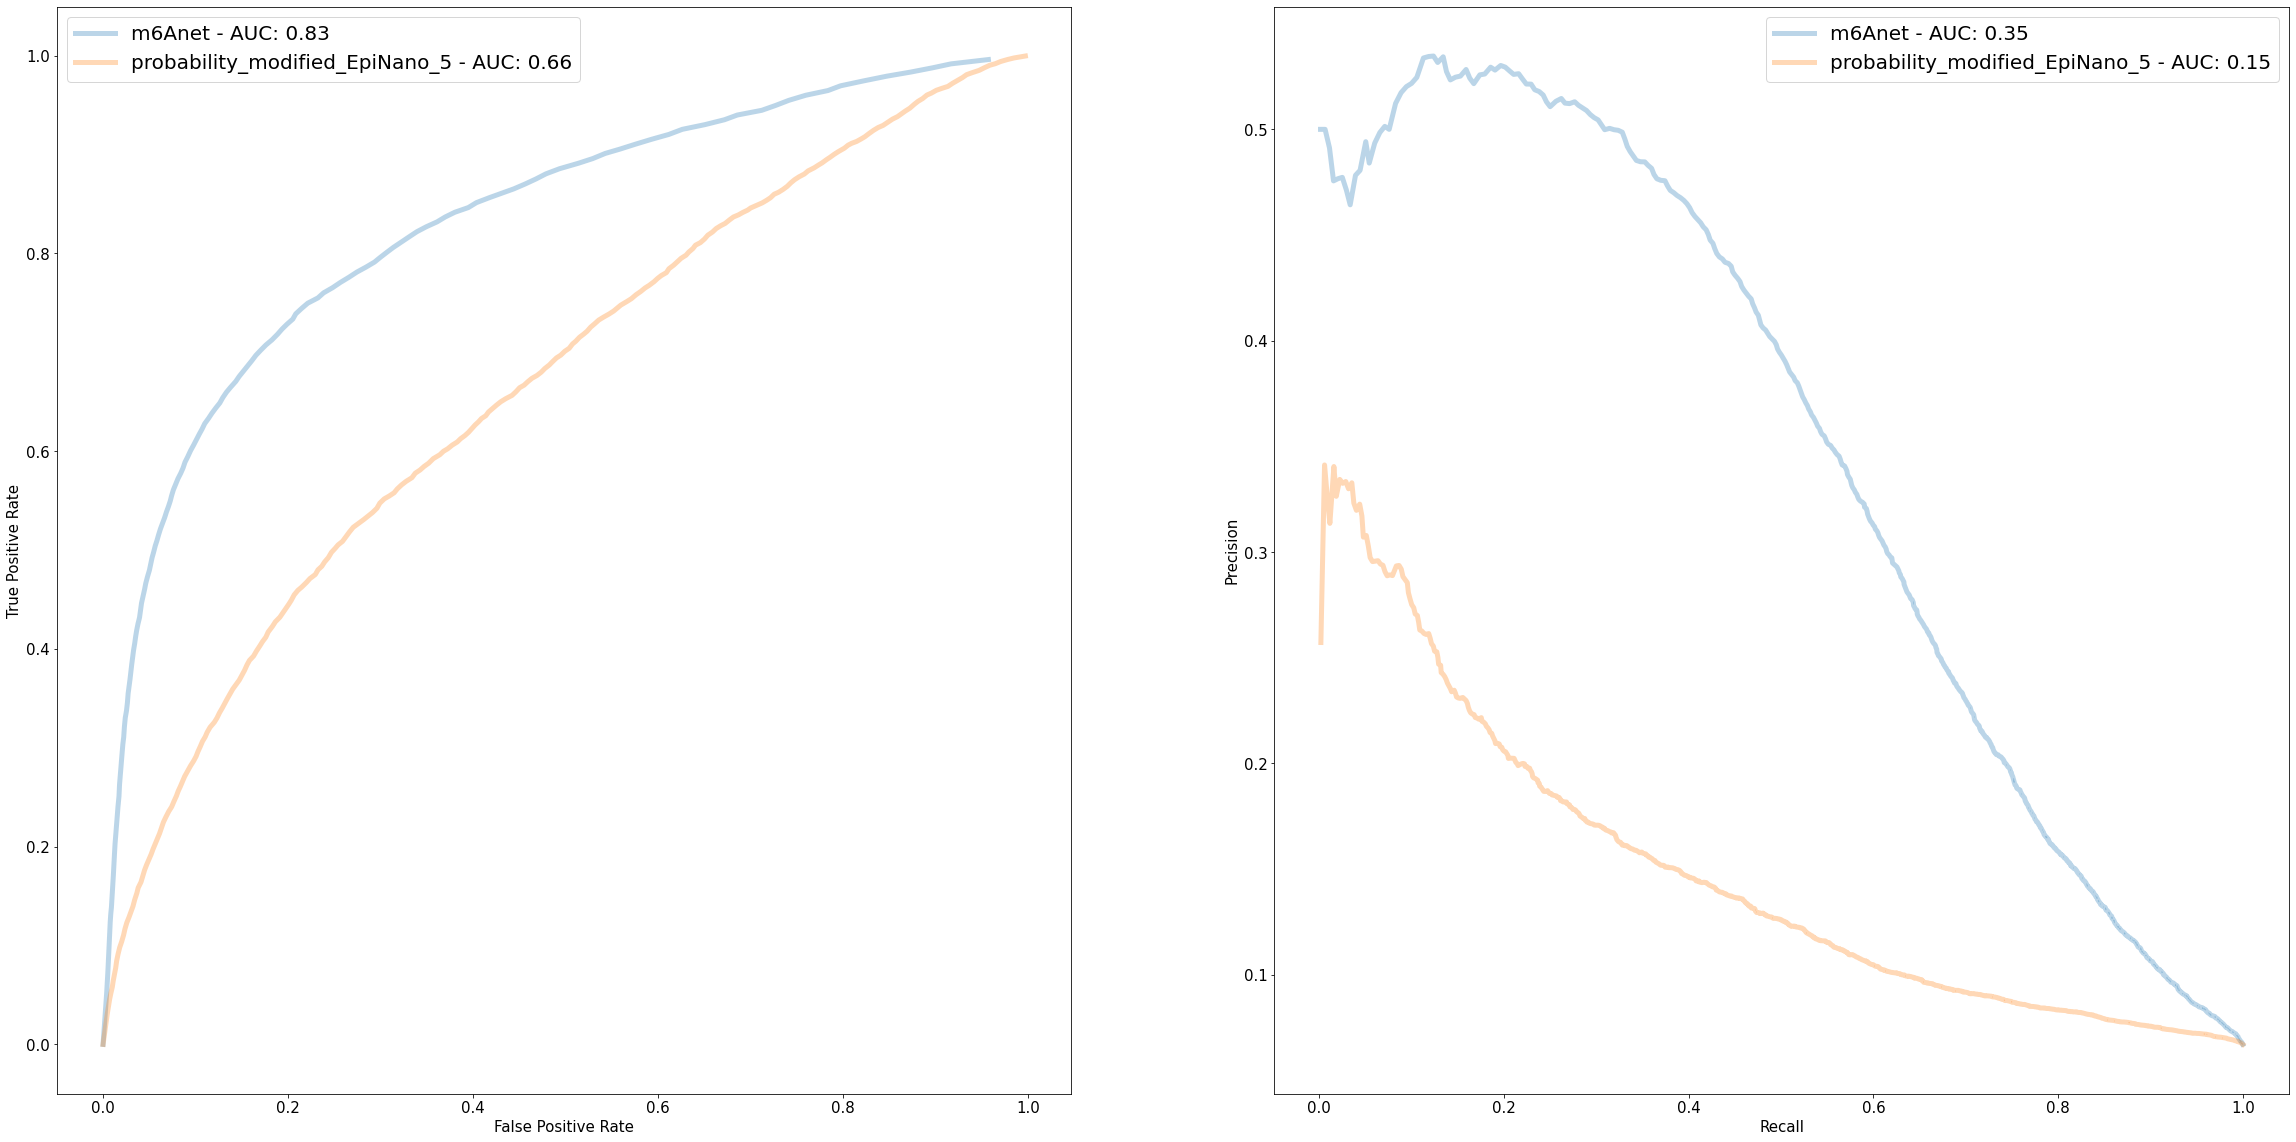

In [18]:
fig_epinano, axes = plt.subplots(1, 2, figsize=(40, 20))
cols = ["probability_modified_m6Anet", "probability_modified_EpiNano_5"]
to_plot = df[cols + ["modification_status"]].dropna()
for model, col in zip(["m6Anet", "probability_modified_EpiNano_5"], cols):
    y_true, y_pred = to_plot["modification_status"].values, to_plot[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0], sample=50)
    plot_pr_curve(y_true, y_pred, model, axes[1], sample=50)
customise_roc_pr_plots(axes)
# fig_epinano.savefig("./Figure_2/m6anet_vs_epinano_full.svg")

m6Anet


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Tombo


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


MINES


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


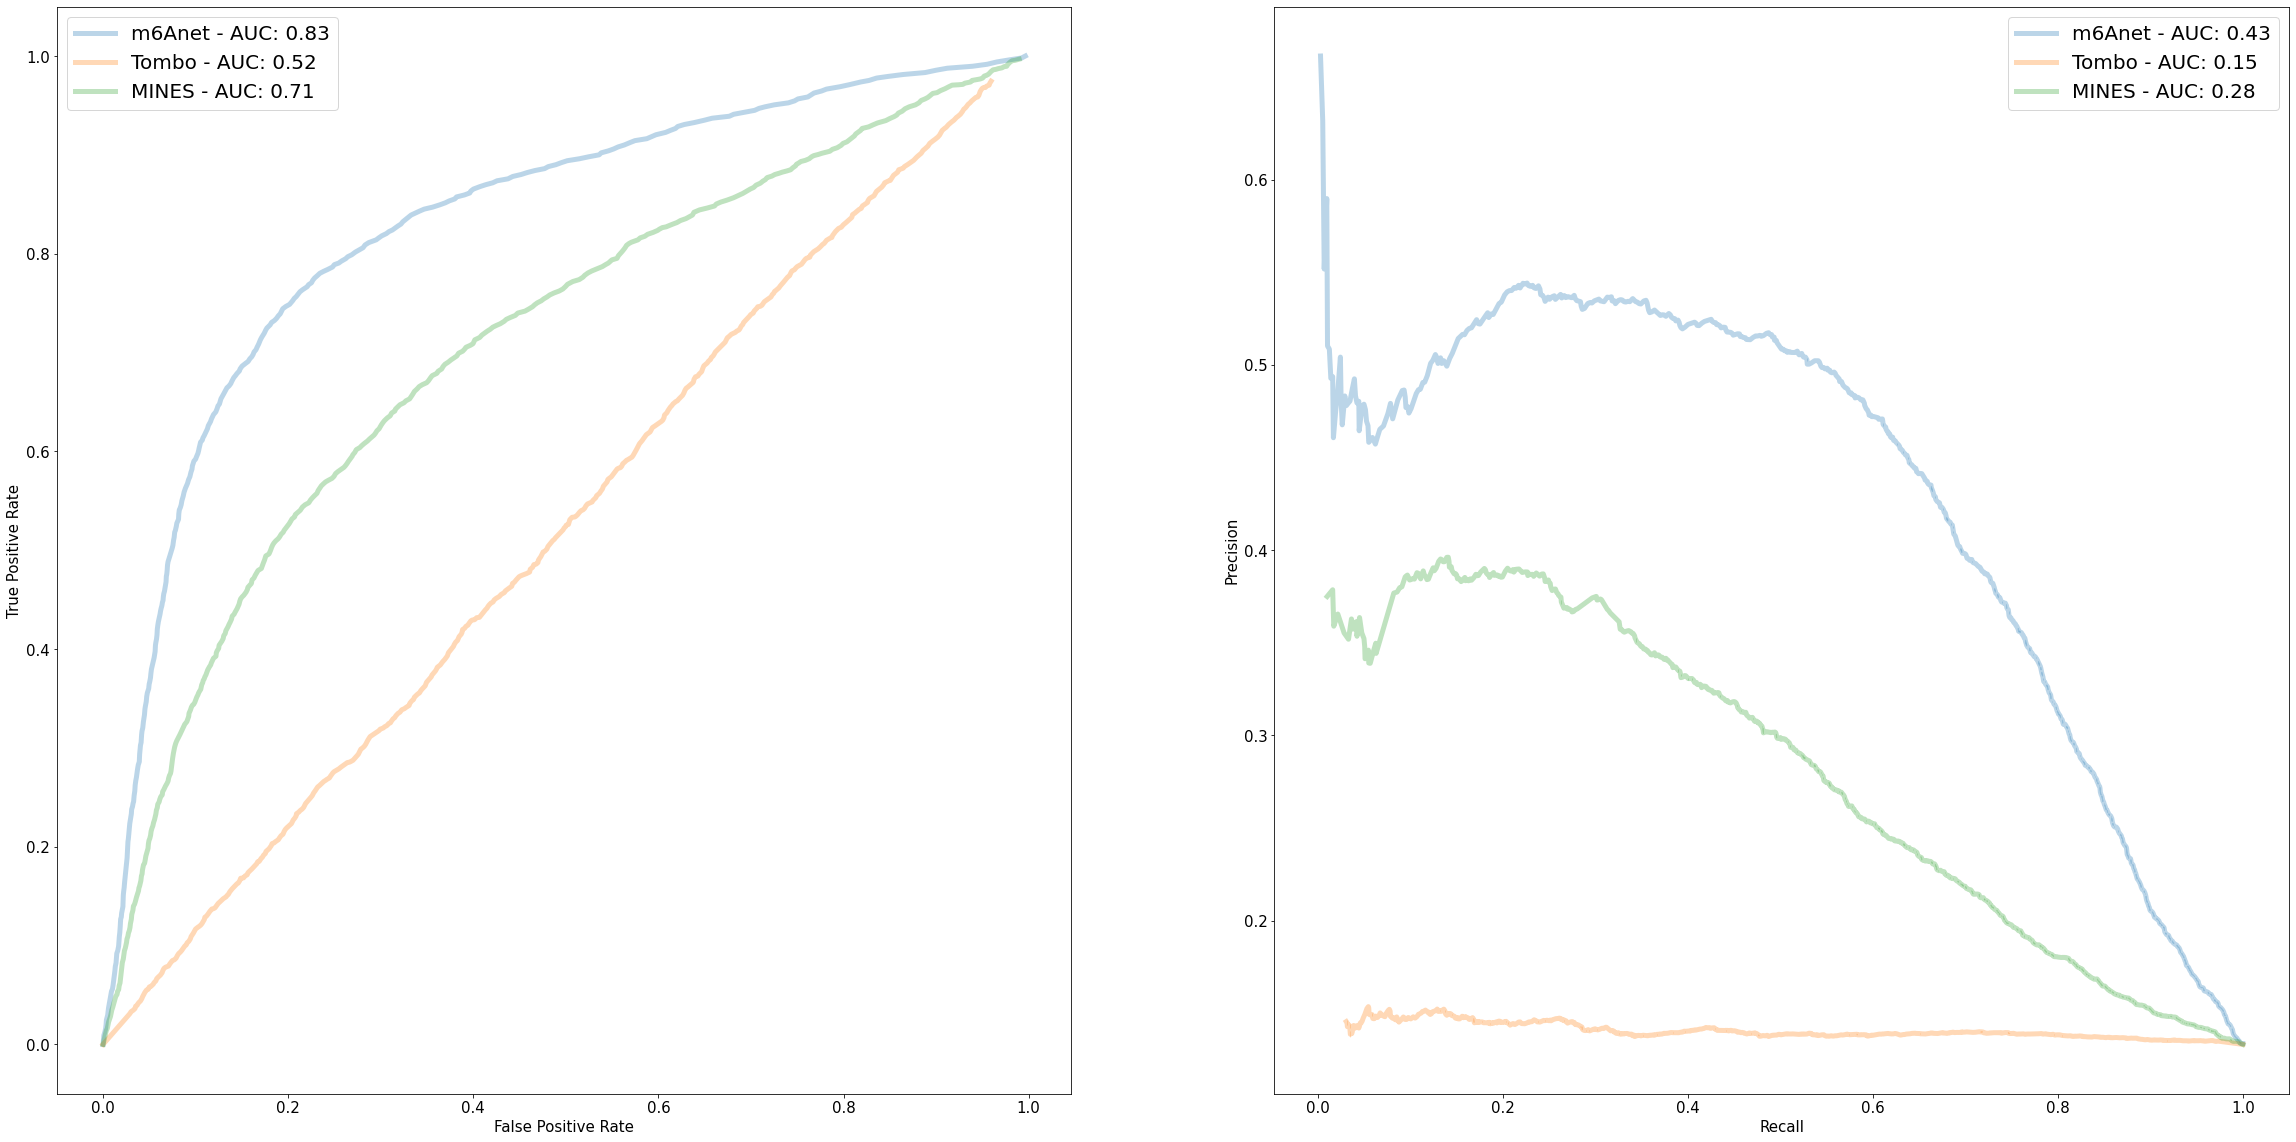

In [19]:
fig_mines, axes = plt.subplots(1, 2, figsize=(40, 20))

cols = ["probability_modified_m6Anet", "probability_modified_tombo", "probability_modified_MINES"]
to_plot = df[cols + ["modification_status"]].dropna()
for model, col in zip(["m6Anet", "Tombo", "MINES"], cols):
    y_true, y_pred = to_plot["modification_status"].values, to_plot[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0], sample=10)
    plot_pr_curve(y_true, y_pred, model, axes[1], sample=10)
customise_roc_pr_plots(axes)
# fig_mines.savefig('./Figure_2/m6anet_vs_mines.svg')

m6Anet


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Tombo
nanom6A


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

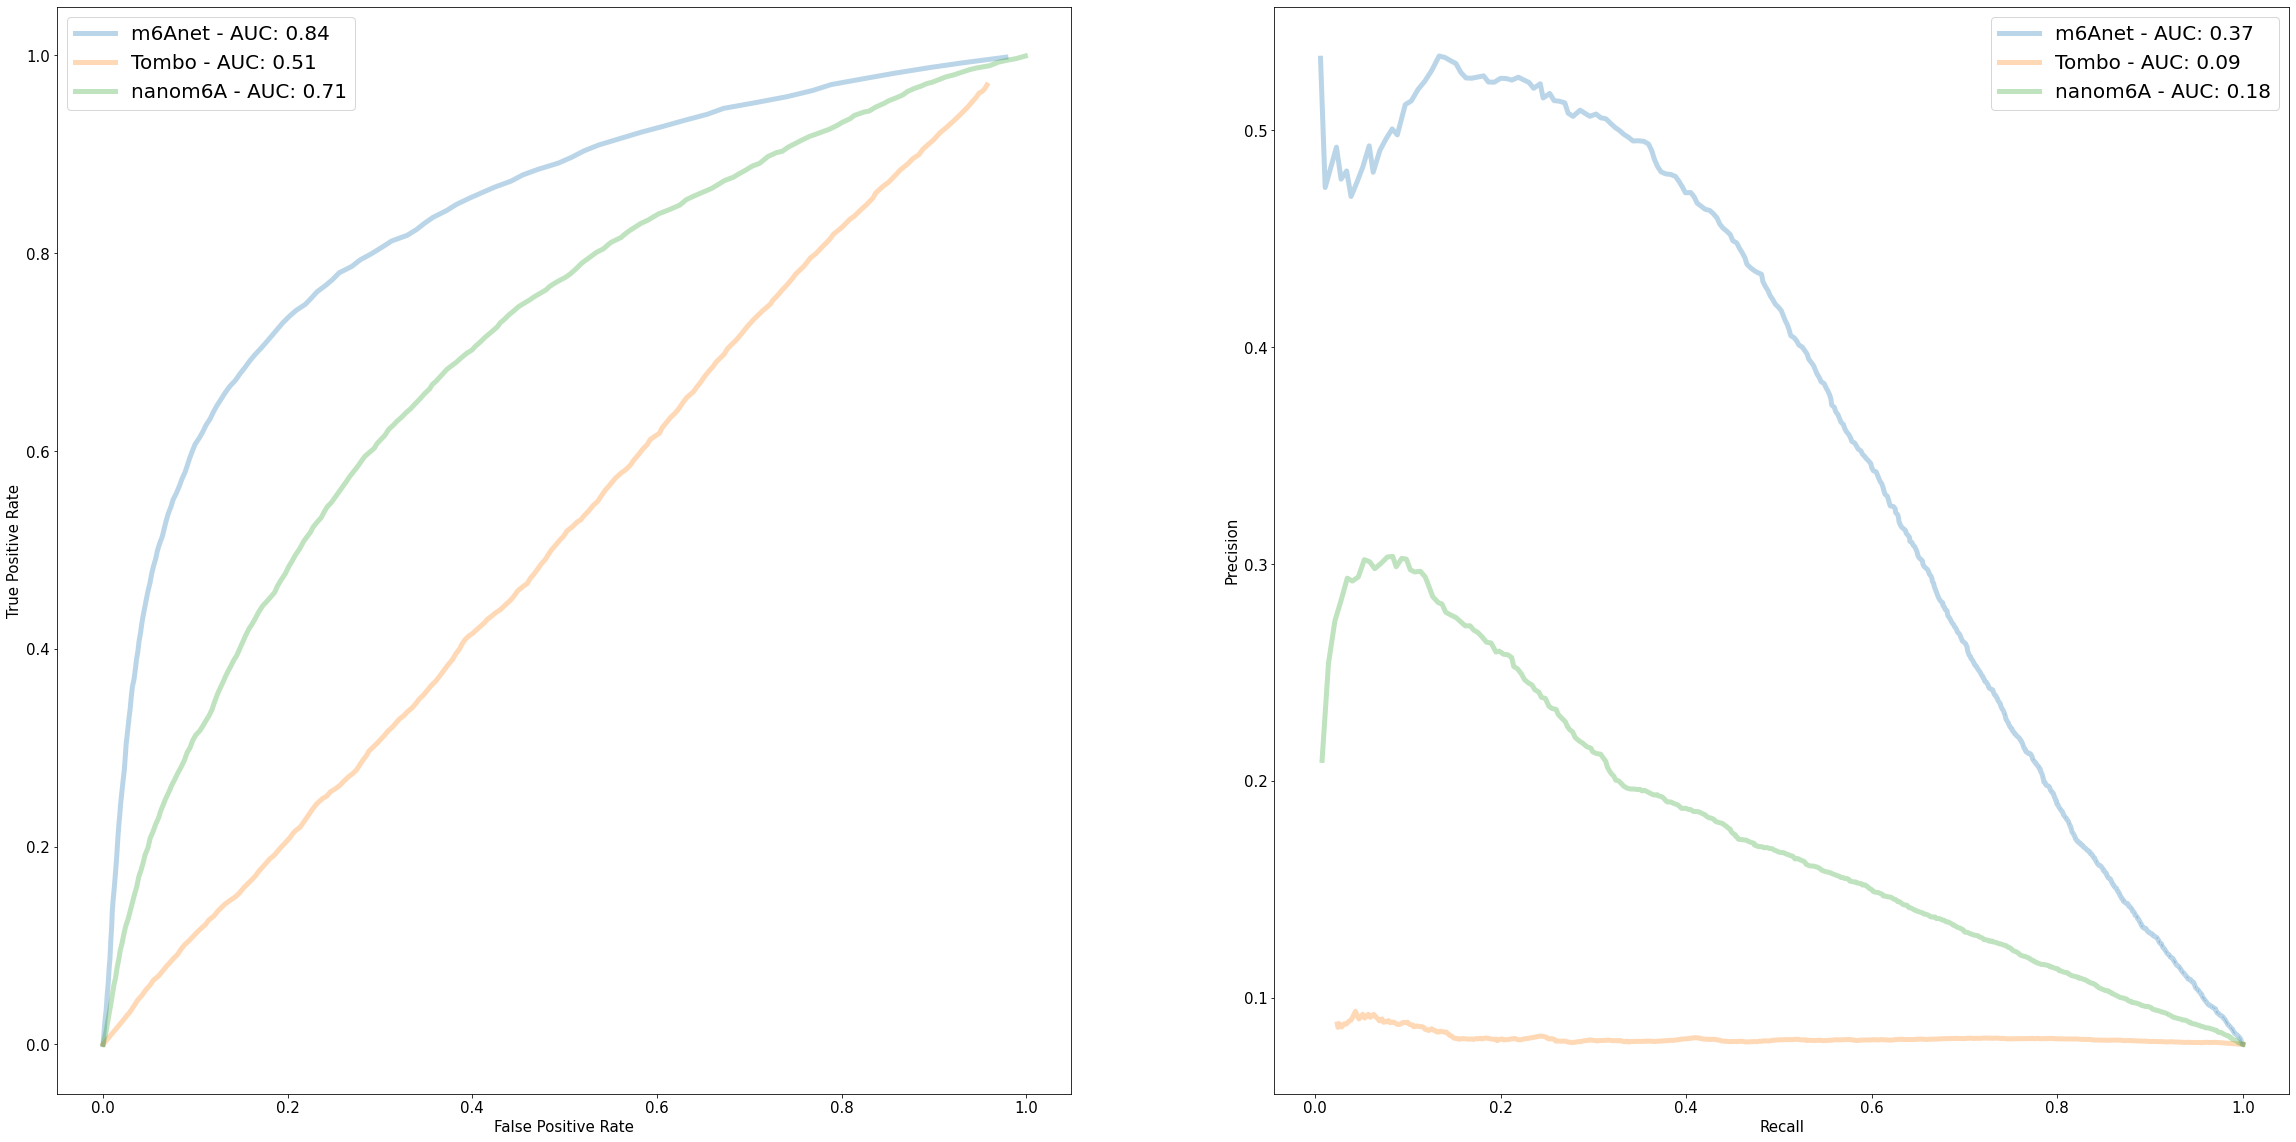

In [21]:
fig_nanom6a, axes = plt.subplots(1, 2, figsize=(40, 20))

cols = ["probability_modified_m6Anet", "probability_modified_tombo", "probability_modified_nanom6a"]
to_plot = df[cols + ["modification_status"]].dropna()

for model, col in zip(["m6Anet", "Tombo", "nanom6A"], cols):
    y_true, y_pred = to_plot["modification_status"].values, to_plot[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0], sample=50)
    plot_pr_curve(y_true, y_pred, model, axes[1], sample=50)
customise_roc_pr_plots(axes)
# fig_nanom6a.savefig('./Figure_2/m6anet_vs_nanom6a.svg')

In [ ]:
fig_epinano, axes = plt.subplots(1, 2, figsize=(40, 20))

cols = ["probability_modified_m6Anet", "probability_modified_tombo",
        "probability_modified_EpiNano_1",
        "probability_modified_EpiNano_2", "probability_modified_EpiNano_3",
        "probability_modified_EpiNano_4", "probability_modified_EpiNano_5"]

to_plot = df[cols + ["modification_status"]].dropna()

for model, col in zip(["m6Anet", "Tombo", "EpiNano Model 1", 
                       "EpiNano Model 2", "EpiNano Model 3", "EpiNano_Model 4", "EpiNano_Model_5"], cols):
    y_true, y_pred = to_plot["modification_status"].values, to_plot[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0])
    plot_pr_curve(y_true, y_pred, model, axes[1])
customise_roc_pr_plots(axes)
fig_epinano.savefig("./Figure_2/m6anet_vs_epinano_all_models.svg")

m6Anet


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Tombo


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano Model 1


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano Model 2


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano Model 3


/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


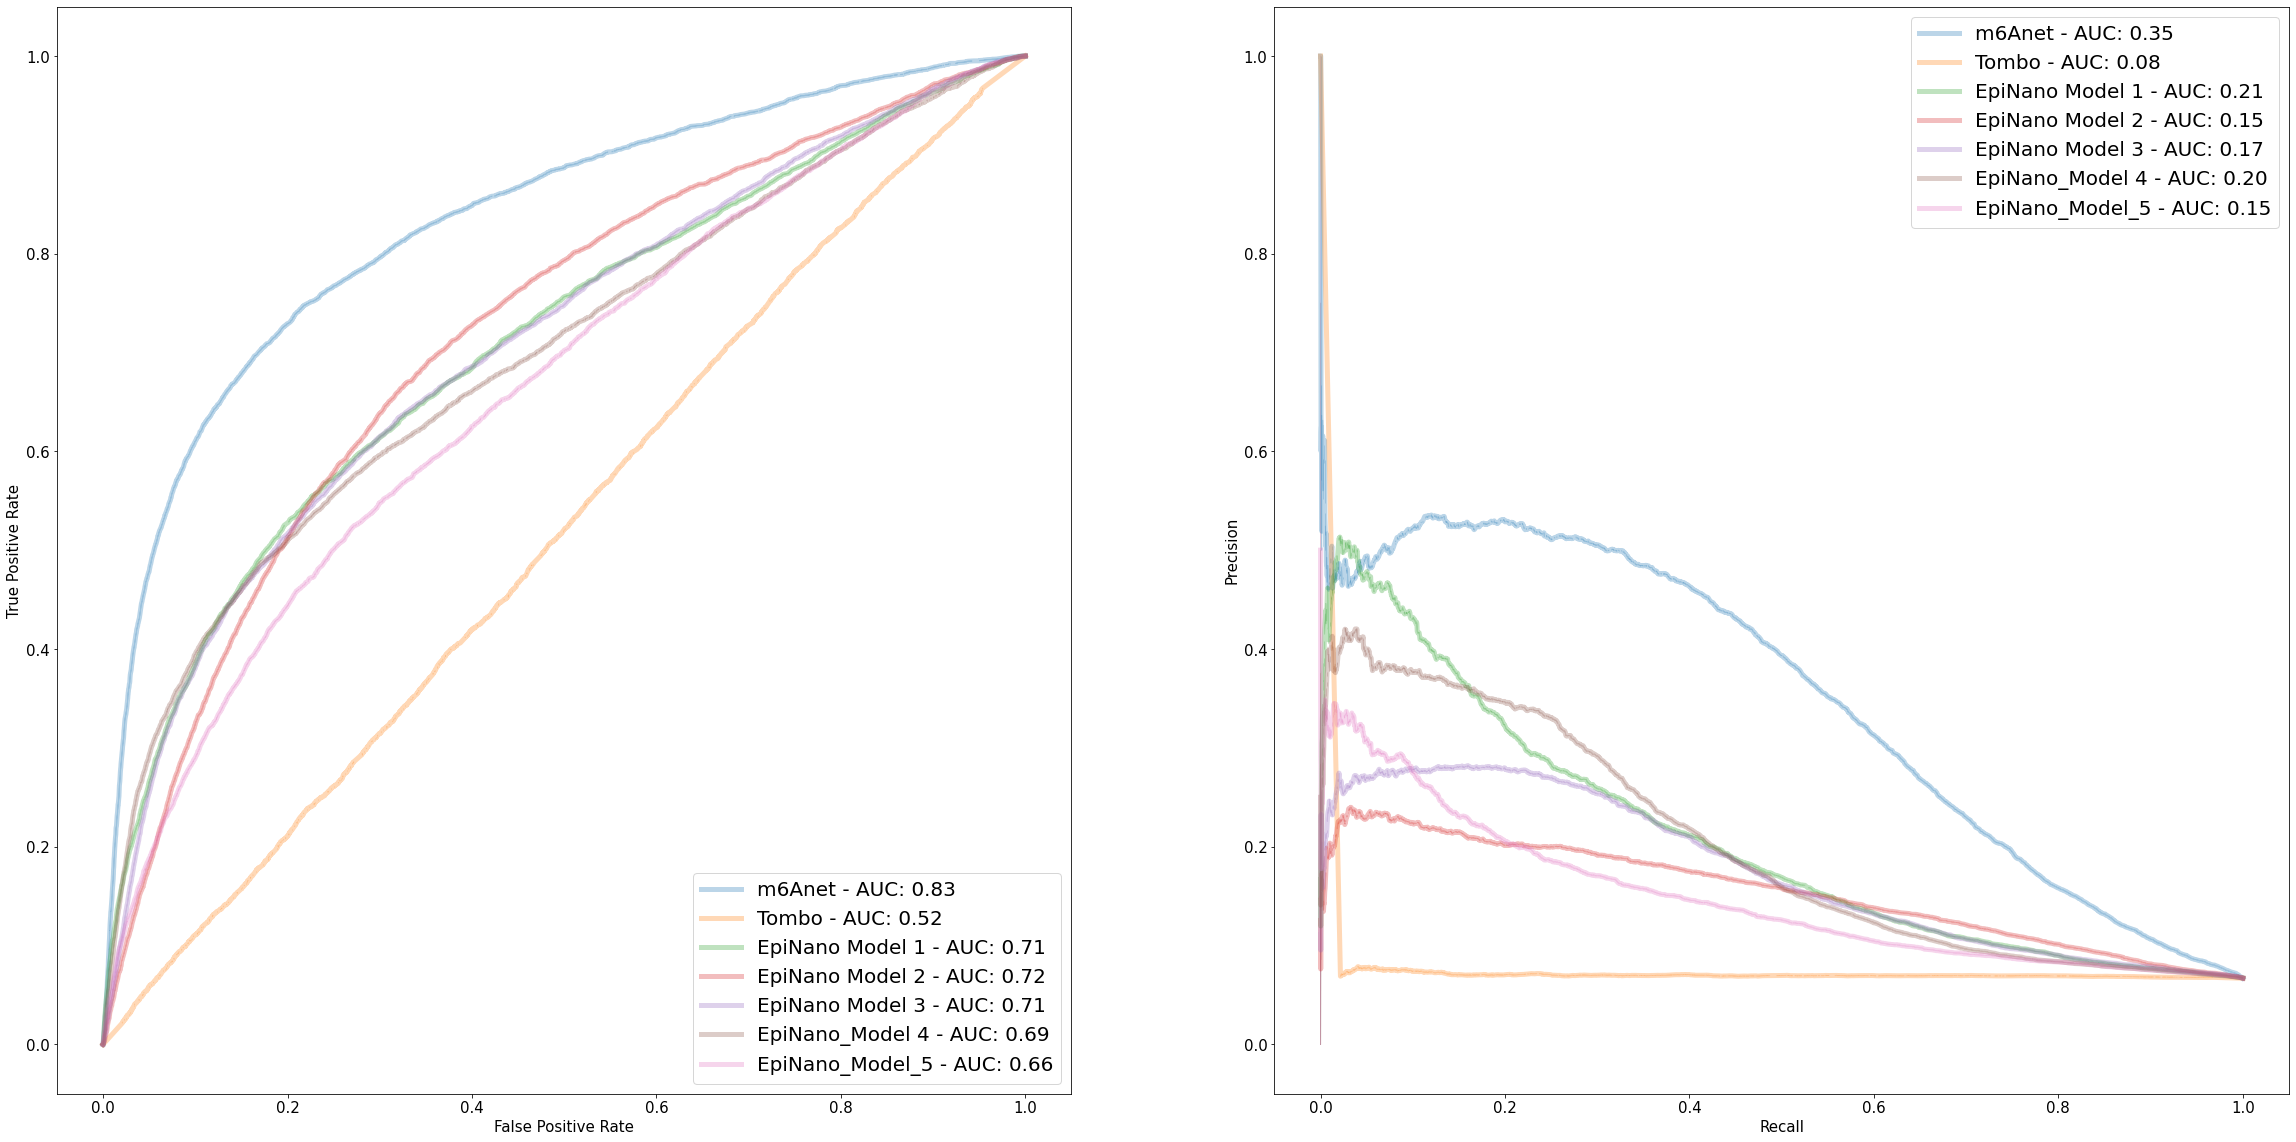

In [49]:
fig_epinano

In [23]:
def get_y(info_df, table, col_name):
    g, chrsm = info_df["genomic_position"].values, info_df["chr"].values
    info_df[col_name] = np.array([1 if (g_pos, chr_id) in table.index else 0
                                               for g_pos, chr_id in tqdm(zip(g, chrsm), total=len(g),
                                               desc="Getting label information")]) 
    return info_df

def add_chromosome_info(info_df):
    info_df["chr"] = info_df["gene_id"].apply(lambda x: chr_map[genome.gene_by_id(x).contig])
    return info_df

def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)

In [24]:
m6ace = pd.read_csv("/mnt/dataHDD/chris/annotations/m6ACE_HEK293T.csv.gz").set_index(["End", "Chr"])
miclip = pd.read_csv("/mnt/dataHDD/chris/annotations/miclip_HEK293T.csv.gz").set_index(["End", "Chr"])
result = add_chromosome_info(df)
result = get_y(df, m6ace, "m6ACE")
result = get_y(df, miclip, "miCLIP")

Getting label information:   0%|          | 0/75371 [00:00<?, ?it/s]

Getting label information:   0%|          | 0/75371 [00:00<?, ?it/s]

/mnt/projects/software/anaconda3/envs/m6anet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [29]:
result = result[["gene_id", "genomic_position", "chr", "kmer", "probability_modified_m6Anet",
        "probability_modified_tombo", "probability_modified_EpiNano_1", "probability_modified_EpiNano_2",
        "probability_modified_EpiNano_3", "probability_modified_EpiNano_4", "probability_modified_EpiNano_5",
        "probability_modified_MINES", "probability_modified_nanom6a", "m6ACE", "miCLIP", "modification_status"]]


In [31]:
cols = ["id", "position", "kmer", "mod_rate_WT", 
        "mod_rate_KO",
        "pval_KO_vs_WT"]
diffmod_table = pd.read_csv("/mnt/dataHDD/chris/diffmod.table", usecols=cols)

In [34]:
result = result.merge(diffmod_table[["pval_KO_vs_WT", "id", "position"]], 
                                   left_on=["gene_id", "genomic_position"], right_on=["id", "position"],
                                   how='left')
result = result.rename(columns={'pval_KO_vs_WT': 'pval'})
result = result.fillna(1)
result["adjusted_pvalue"] = multipletests(result["pval"])[1]


In [36]:
result = result[["gene_id", "genomic_position", "chr", "kmer", "probability_modified_m6Anet",
        "probability_modified_tombo", "probability_modified_EpiNano_1", "probability_modified_EpiNano_2",
        "probability_modified_EpiNano_3", "probability_modified_EpiNano_4", "probability_modified_EpiNano_5",
        "probability_modified_MINES", "probability_modified_nanom6a", "m6ACE", "miCLIP", "modification_status",
        "adjusted_pvalue"]]

In [38]:
result.to_csv("~/hek293t_results.csv", index=False)

In [14]:
result = pd.read_csv("~/hek293t_results.csv")

In [15]:
result = result.rename({'adjusted_pvalue': 'adjusted_pvalue_xPore'}, axis=1)

In [16]:
from statsmodels.stats.multitest import multipletests
 
wt_ko_table = pd.read_csv("~/ttest_results.csv.gz")
wt_ko_table["adjusted_pvalue_ttest"] = multipletests(wt_ko_table.pvalue, alpha=0.05, method='fdr_bh')[1]

result = result.merge(wt_ko_table[["adjusted_pvalue_ttest", "gene_id", "genomic_position"]], 
                                   on=["gene_id", "genomic_position"],
                                   how='left')
result = result.fillna(1)

In [18]:
result.to_csv("~/hek293t_results.csv", index=False)

In [ ]:
fig_epinano, axes = plt.subplots(1, 2, figsize=(40, 20))
for model, col in zip(["m6Anet", "Logit Benchmark", "Tombo", "EpiNano Model 1", 
                       "EpiNano Model 2", "EpiNano Model 3", "EpiNano_Model 4"], 
                      ["probability_modified_prod_pooling", "probability_modified_mean_logit",
                       "probability_modified_tombo",
                       "probability_modified_SVM20_model1", "probability_modified_SVM20_model2",
                       "probability_modified_SVM100_model1", "probability_modified_SVM100_model2"]):
    y_true, y_pred = epinano_df["modification_status_y"].values, epinano_df[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0], sample=50)
    plot_pr_curve(y_true, y_pred, model, axes[1], sample=50)
customise_roc_pr_plots(axes)
fig_epinano.savefig("./Figure_2/m6anet_vs_epinano.svg")

m6Anet


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Logit Benchmark


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Tombo


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


MINES


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


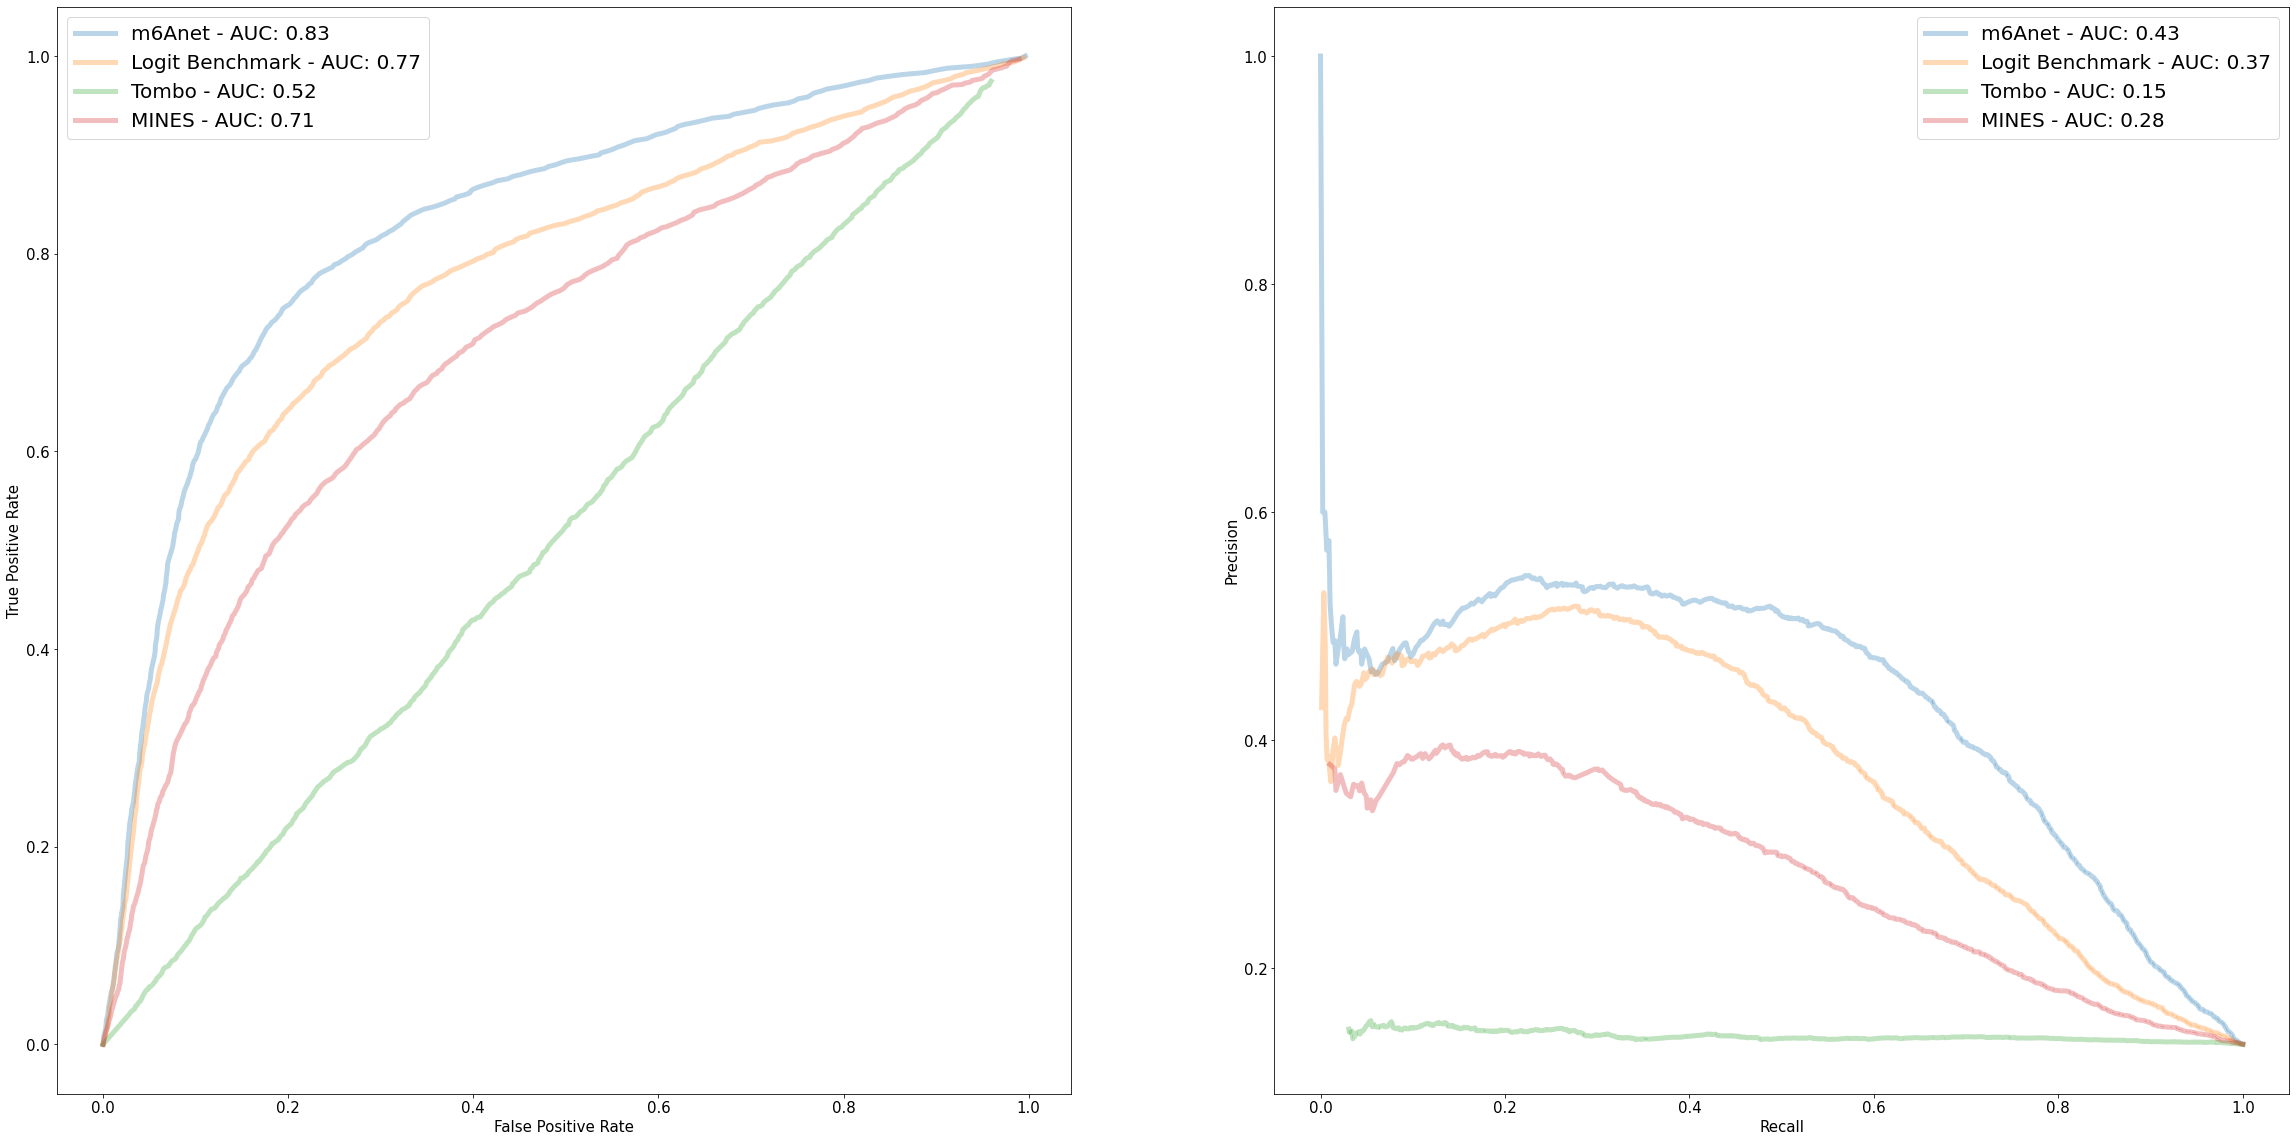

In [10]:
fig_mines, axes = plt.subplots(1, 2, figsize=(40, 20))

for model, col in zip(["m6Anet", "Logit Benchmark", "Tombo", "MINES"], ["probability_modified_prod_pooling",
                                                                        "probability_modified_mean_logit",
                                                  "probability_modified_tombo",
                                                  "probability_modified_MINES"]):
    y_true, y_pred = mines_results["modification_status_y"].values, mines_results[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0], sample=10)
    plot_pr_curve(y_true, y_pred, model, axes[1], sample=10)
customise_roc_pr_plots(axes)
fig_mines.savefig('./Figure_2/m6anet_vs_mines.svg')

In [23]:
# ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
# alpha = 0.005
# result_df_agg = df.groupby(["gene_id", "genomic_position"]).mean()
# result_df_agg = result_df_agg.merge(ko_table, on=["gene_id", "genomic_position"])
# result_df_agg["pvalue"] = multipletests(result_df_agg.pvalue, alpha=alpha, method='fdr_bh')[1]


In [54]:
cols = ["id", "position", "kmer", "mod_rate_WT", 
        "mod_rate_KO",
        "pval_KO_vs_WT"]
diffmod_table = pd.read_csv("/data03/christopher/diffmod.table", usecols=cols)

In [59]:
df = df.merge(diffmod_table[["pval_KO_vs_WT", "id", "position"]], 
                                   left_on=["gene_id", "genomic_position"], right_on=["id", "position"],
                                   how='left')
df = df.rename(columns={'pval_KO_vs_WT': 'pval'})
df = df.fillna(1)
df["adjusted_pvalue"] = multipletests(epinano_df_pval["pval"])[1]
df[["gene_id", "genomic_position", "probability_modified_EpiNano_1", 
             "probability_modified_EpiNano_2", "probability_modified_EpiNano_3",
             "probability_modified_EpiNano_4", "probability_modified_EpiNano_5",
             "probability_modified_tombo",
             "probability_modified_m6Anet", "modification_status", "adjusted_pvalue"]].to_csv("results_pvalue.csv")

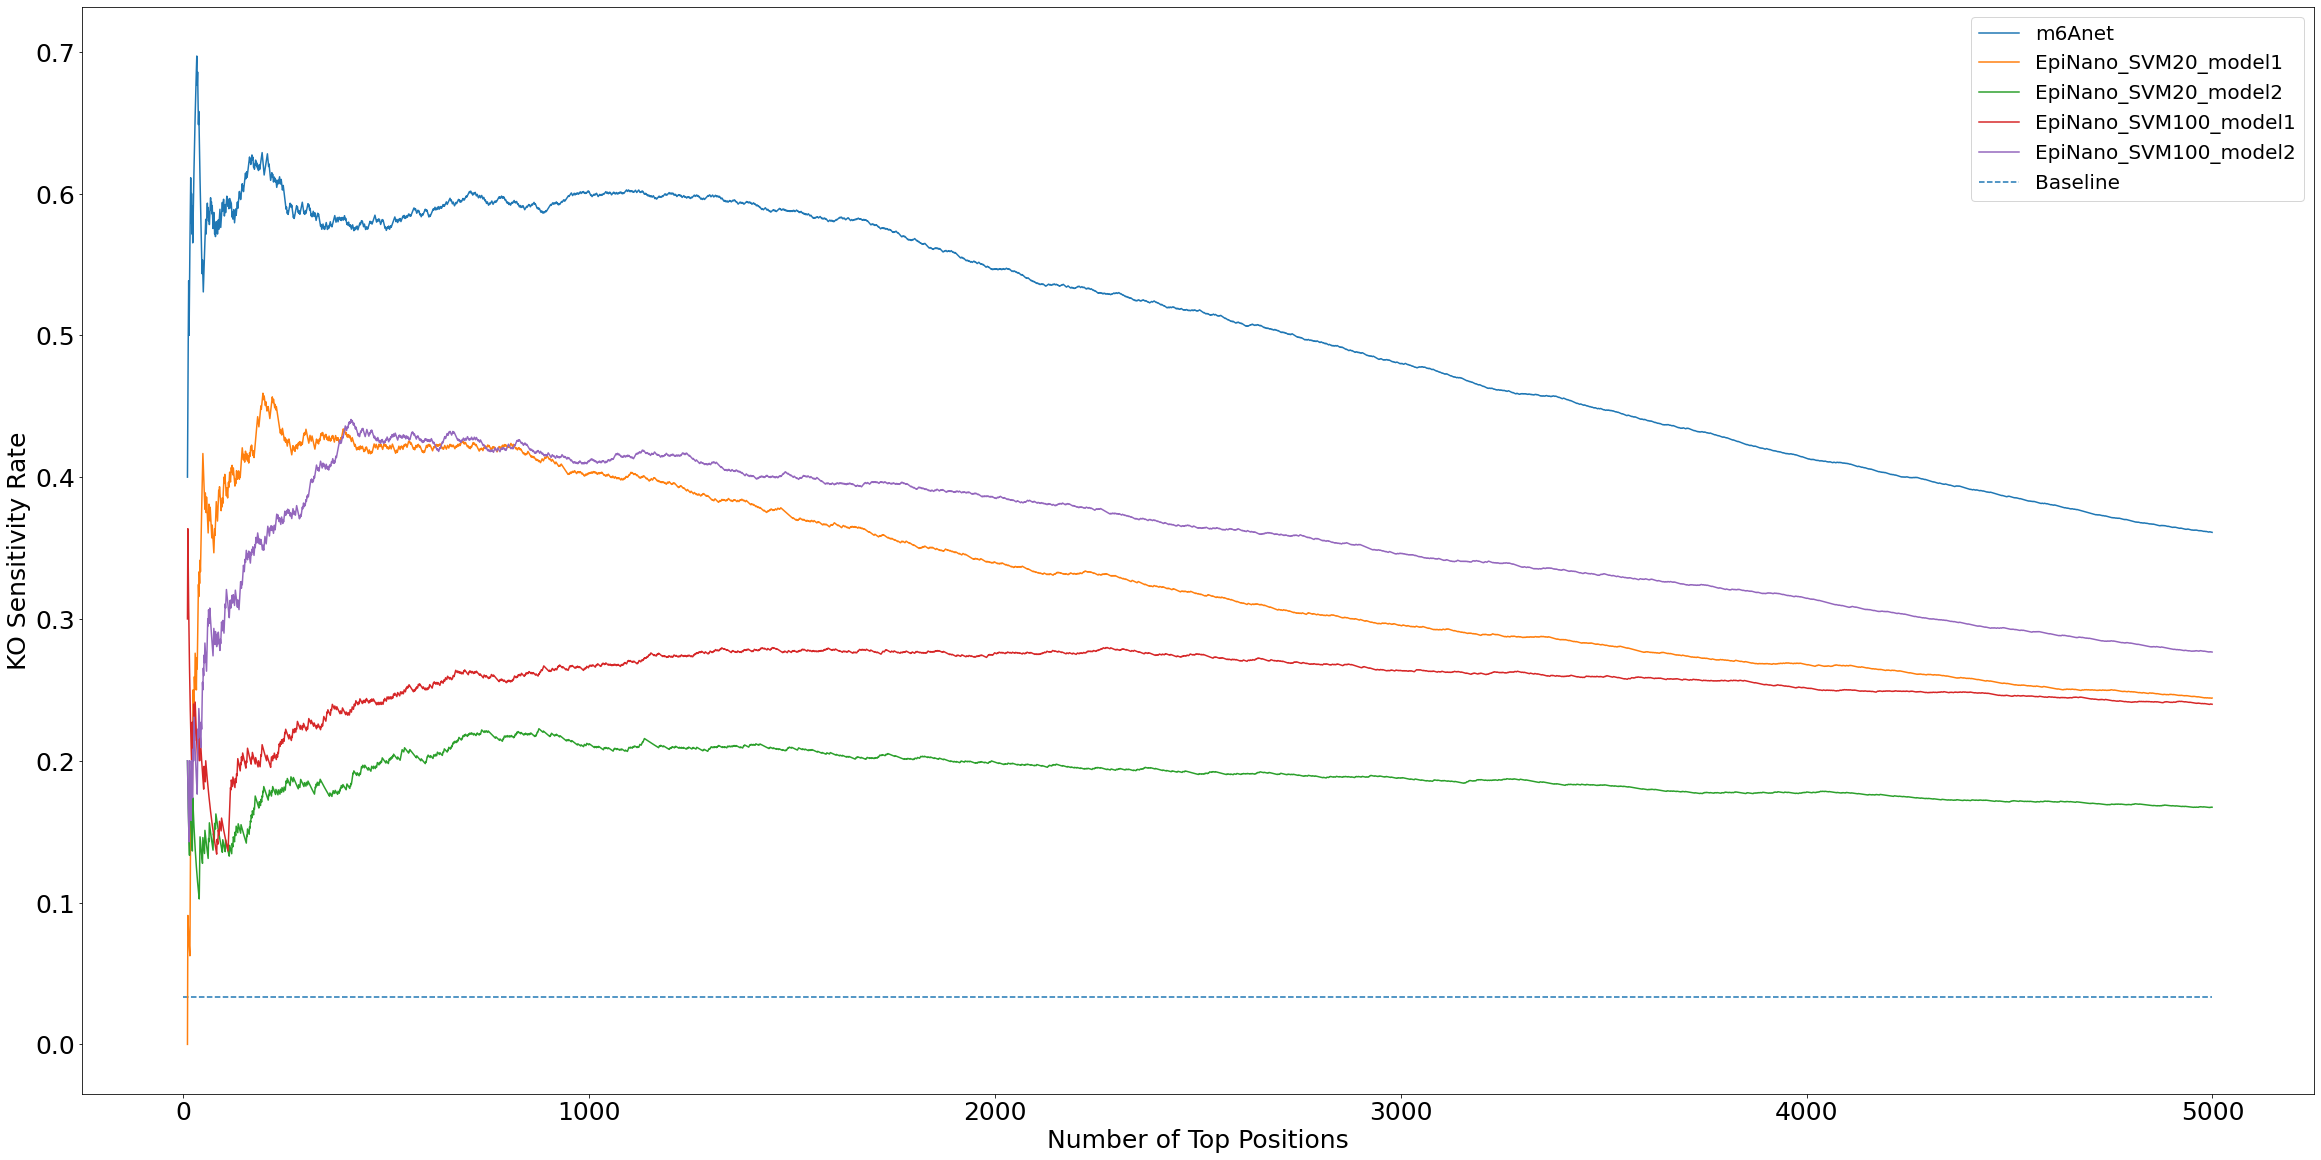

In [230]:
top_n = np.arange(10, 5000)
epinano_df_pval["ko_sens"] = (epinano_df_pval["pval_adj"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col in zip(["m6Anet", "EpiNano_SVM20_model1", "EpiNano_SVM20_model2", "EpiNano_SVM100_model1", 
                       "EpiNano_SVM100_model2"], ["probability_modified_prod_pooling",
                                                  "probability_modified_SVM20_model1",
                                                  "probability_modified_SVM20_model2",
                                                  "probability_modified_SVM100_model1",
                                                  "probability_modified_SVM100_model2"]):
    to_plot = epinano_df_pval.sort_values(col, ascending=False)
    ko_sensitivities = [to_plot["ko_sens"].head(n=n).mean() for n in top_n]
    sns.lineplot(x=top_n, y=ko_sensitivities, label=model, ax=ax)

baseline = epinano_df_pval["ko_sens"].mean()

ax.hlines(baseline, xmin=0, xmax=5000, linestyles="--", label="Baseline")
plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('KO Sensitivity Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})
# fig.savefig('m6anet_vs_epinano_ko_rate.svg')

<ipython-input-44-74d7c0a45ef6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["ko_sens"] = (result["adjusted_pvalue"] < 0.05) * 1


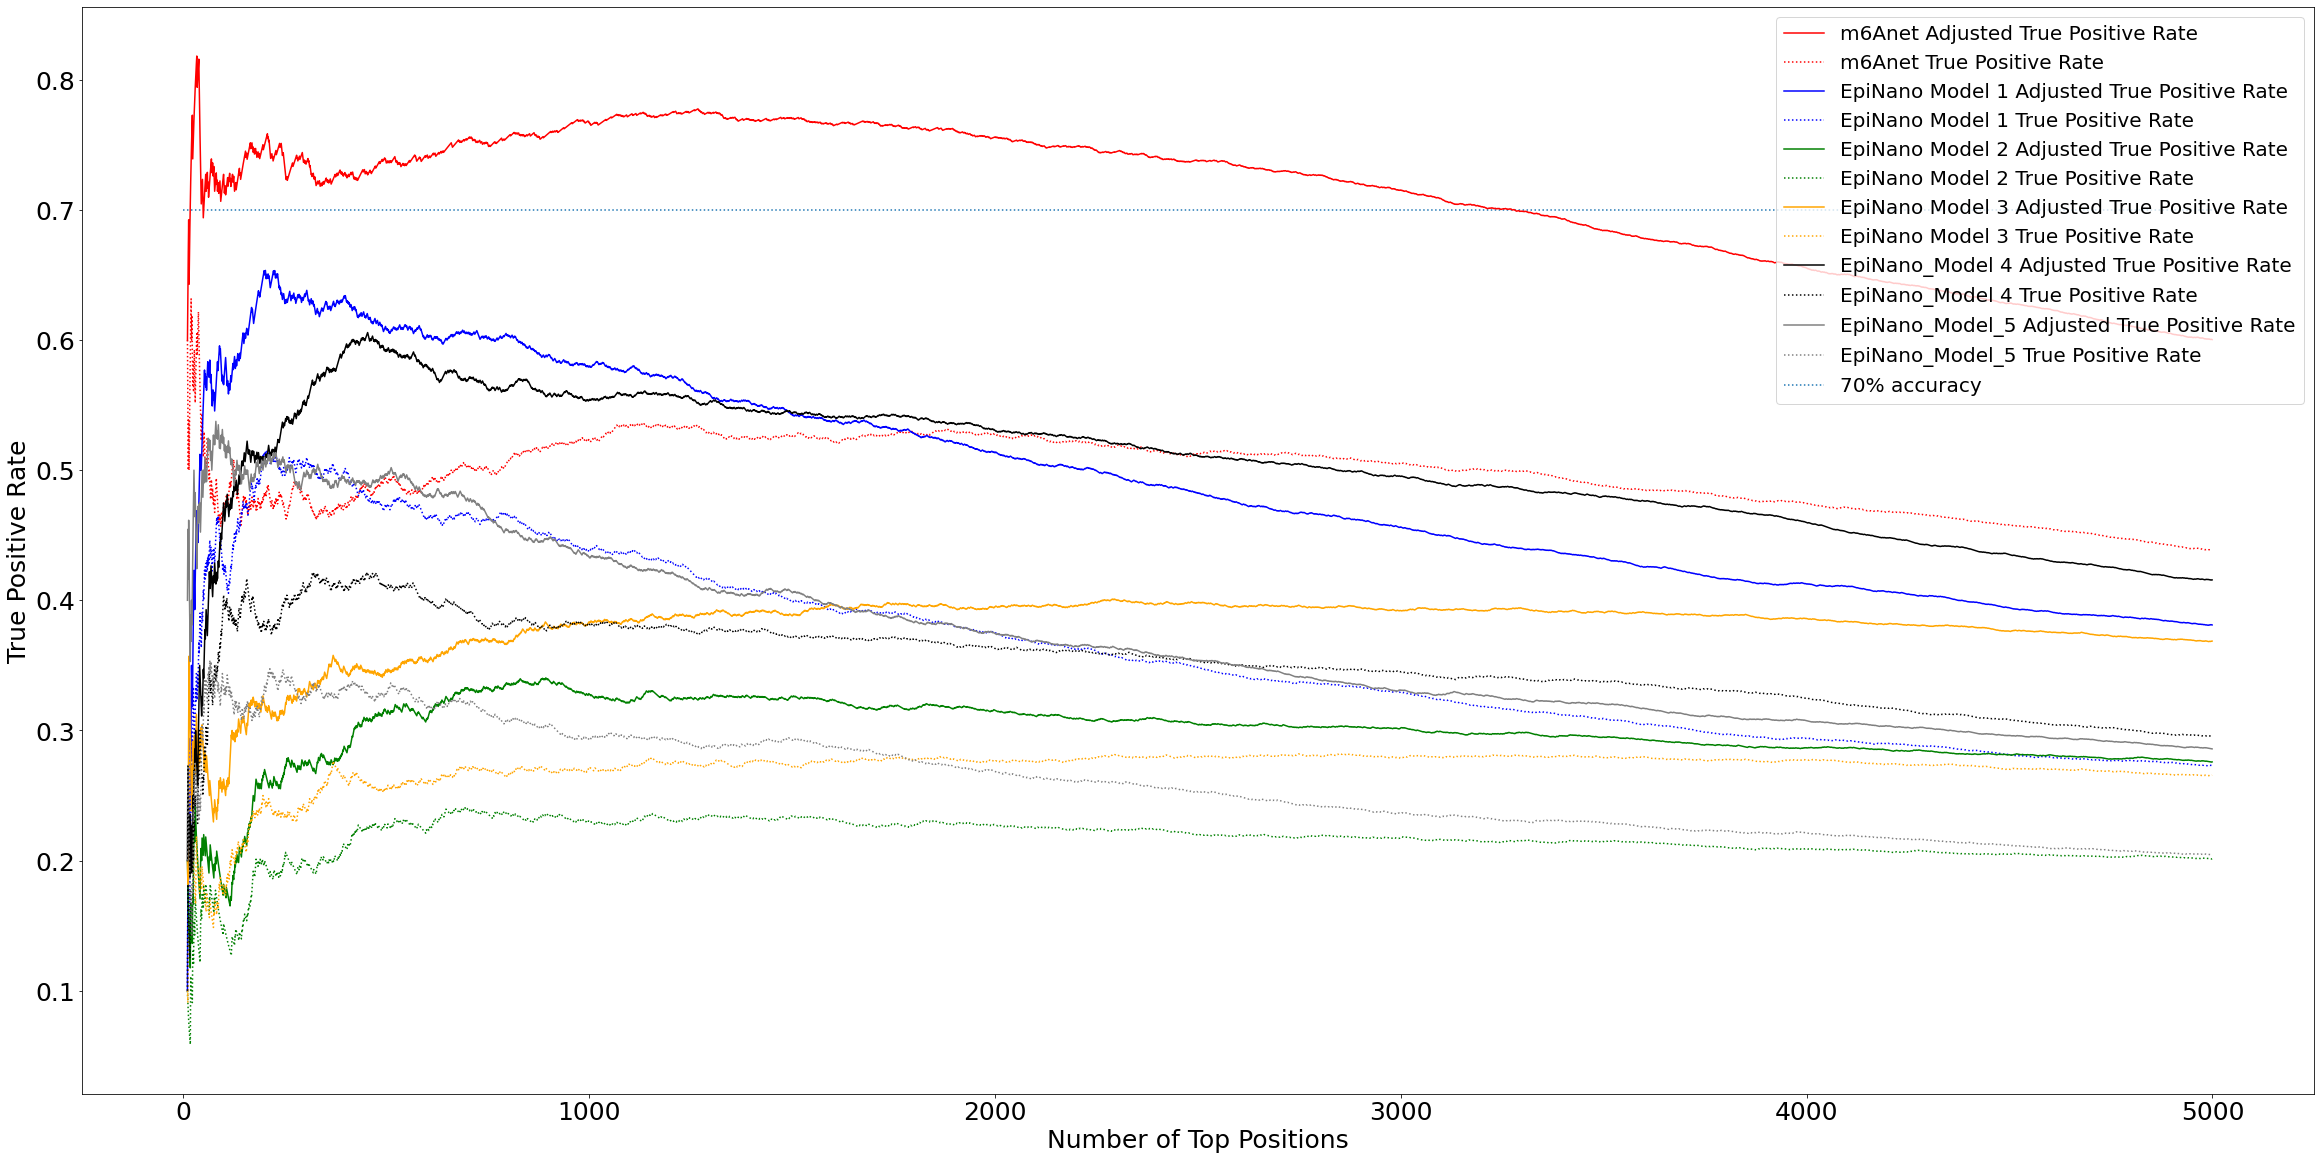

In [44]:
top_n = np.arange(10, 5000)
result["ko_sens"] = (result["adjusted_pvalue"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col, color in zip(["m6Anet", "EpiNano Model 1", 
                              "EpiNano Model 2", "EpiNano Model 3", "EpiNano_Model 4", "EpiNano_Model_5"], 
                             ["probability_modified_m6Anet",
                              "probability_modified_EpiNano_1",
                              "probability_modified_EpiNano_2", "probability_modified_EpiNano_3",
                              "probability_modified_EpiNano_4", "probability_modified_EpiNano_5"],
                             ['red', 'blue', 'green', 'orange', 'black', 'grey']):
    to_plot = result.sort_values(col, ascending=False)
    
    ko_sensitivities = to_plot["ko_sens"].values
    modification_status = to_plot["modification_status"].values
    
    adjusted_tpr = np.array([np.mean((np.logical_or(ko_sensitivities[:n], modification_status[:n]))) for n in top_n])
    tpr = np.array([np.mean((modification_status[:n]))for n in top_n])

    sns.lineplot(x=top_n, y=adjusted_tpr, label=model + " Adjusted True Positive Rate", ax=ax, linestyle="solid", color=color)
    sns.lineplot(x=top_n, y=tpr, label=model + " True Positive Rate", ax=ax, linestyle="dotted", color=color)
    
ax.hlines(0.7, xmin=0, xmax=5000, linestyles="dotted", label="70% accuracy")
plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('True Positive Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})
fig.savefig('./Figure_2/m6anet_vs_epinano_adjusted_tpr_all.svg')

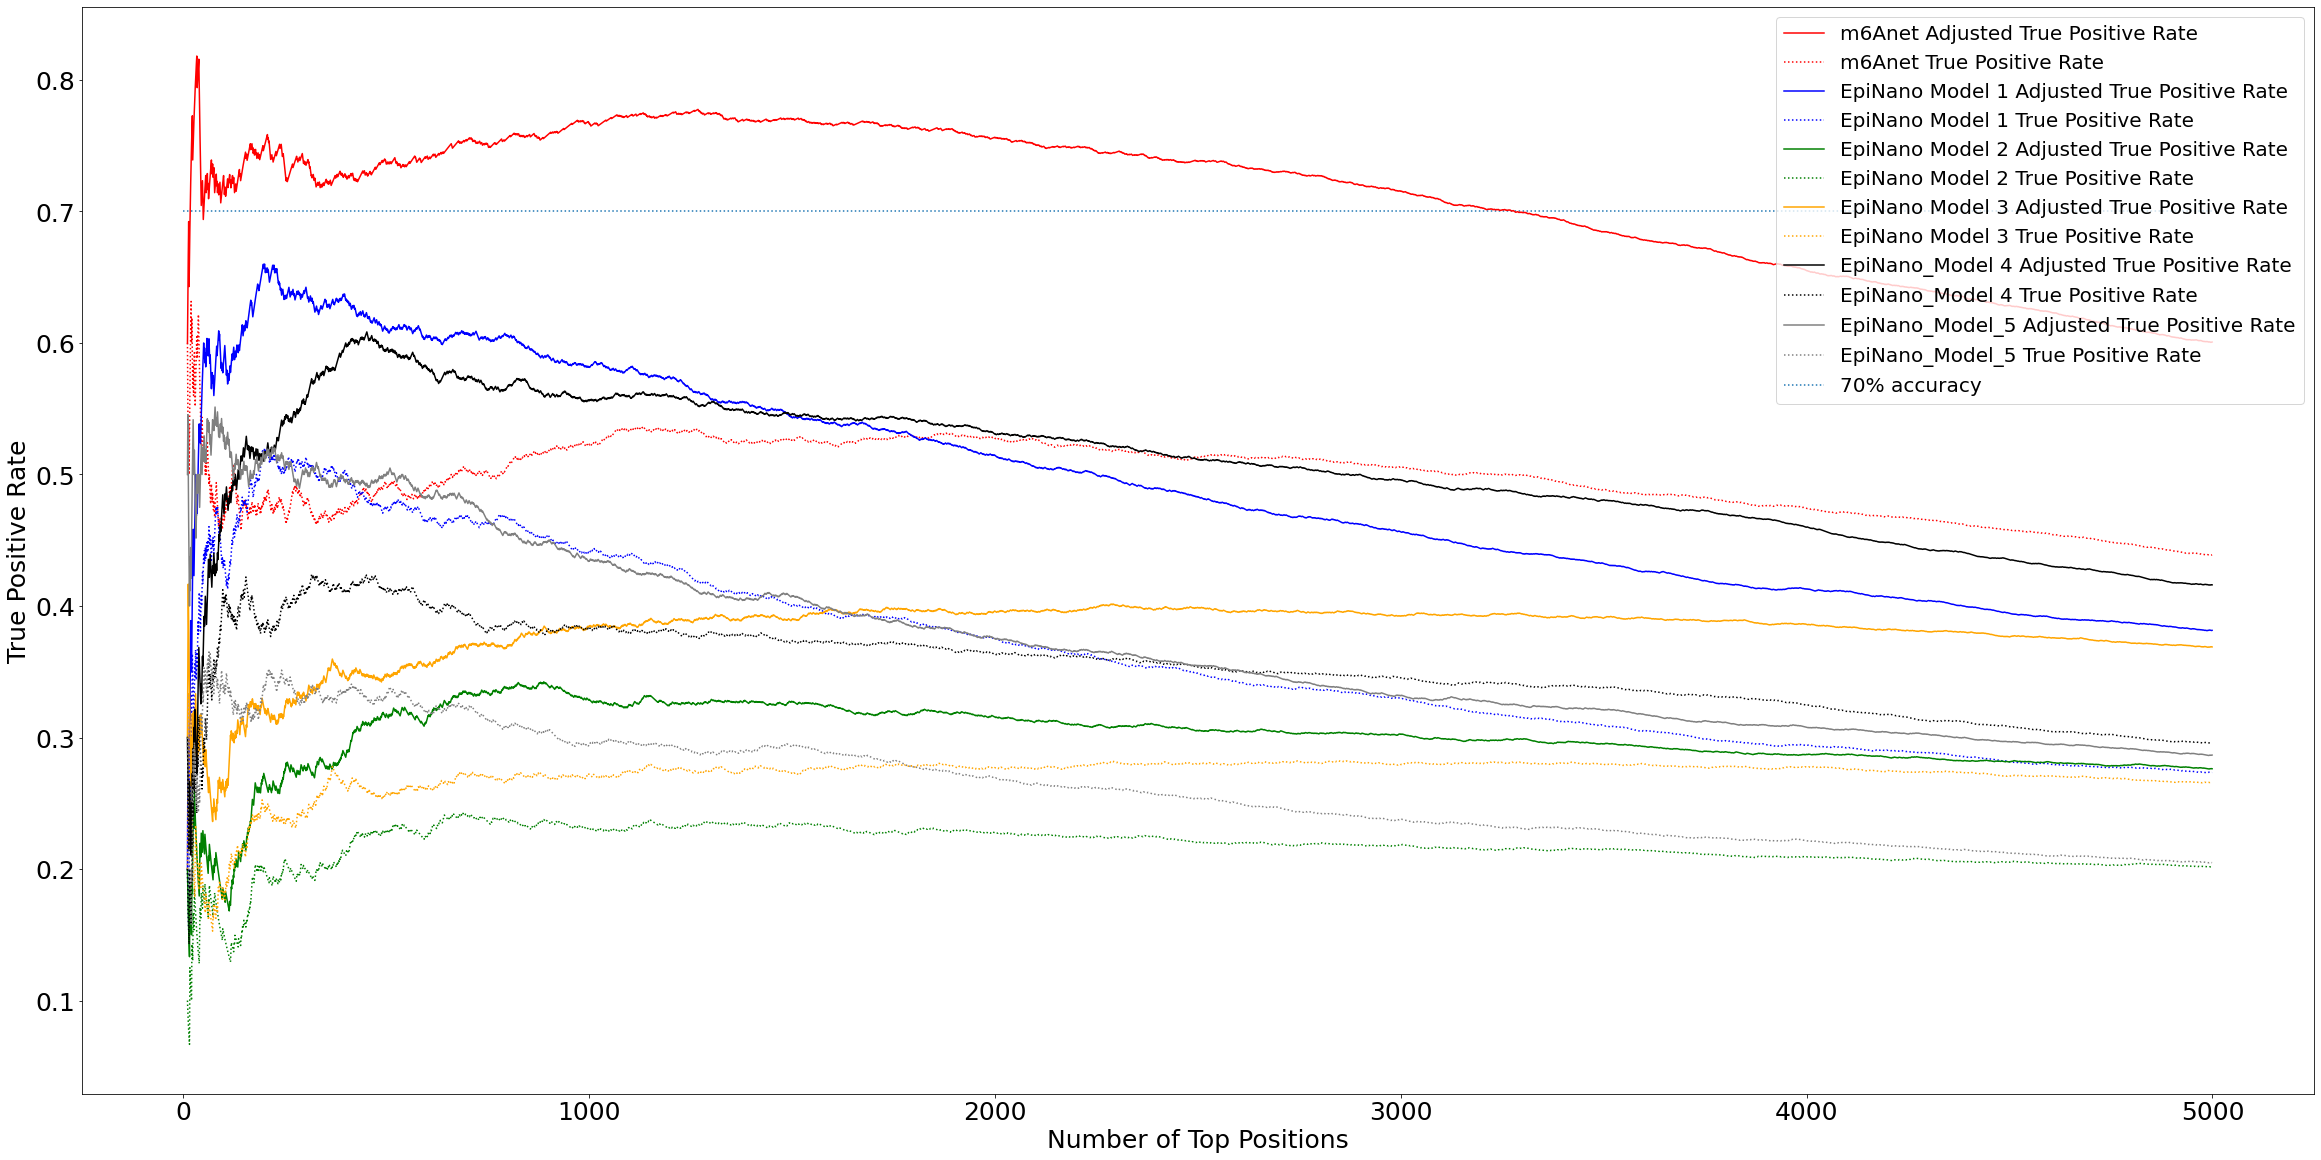

In [63]:
top_n = np.arange(10, 5000)
epinano_df_pval["ko_sens"] = (epinano_df_pval["adjusted_pvalue"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col, color in zip(["m6Anet", "EpiNano Model 1", 
                              "EpiNano Model 2", "EpiNano Model 3", "EpiNano_Model 4", "EpiNano_Model_5"], 
                             ["probability_modified_m6Anet",
                              "probability_modified_EpiNano_1",
                              "probability_modified_EpiNano_2", "probability_modified_EpiNano_3",
                              "probability_modified_EpiNano_4", "probability_modified_EpiNano_5"],
                             ['red', 'blue', 'green', 'orange', 'black', 'grey']):
    to_plot = epinano_df_pval.sort_values(col, ascending=False)
    
    ko_sensitivities = to_plot["ko_sens"].values
    modification_status = to_plot["modification_status"].values
    
    adjusted_tpr = np.array([np.mean((np.logical_or(ko_sensitivities[:n], modification_status[:n]))) for n in top_n])
    tpr = np.array([np.mean((modification_status[:n]))for n in top_n])

    sns.lineplot(x=top_n, y=adjusted_tpr, label=model + " Adjusted True Positive Rate", ax=ax, linestyle="solid", color=color)
    sns.lineplot(x=top_n, y=tpr, label=model + " True Positive Rate", ax=ax, linestyle="dotted", color=color)
    
ax.hlines(0.7, xmin=0, xmax=5000, linestyles="dotted", label="70% accuracy")
plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('True Positive Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})
fig.savefig('m6anet_vs_epinano_adjusted_tpr_all.svg')

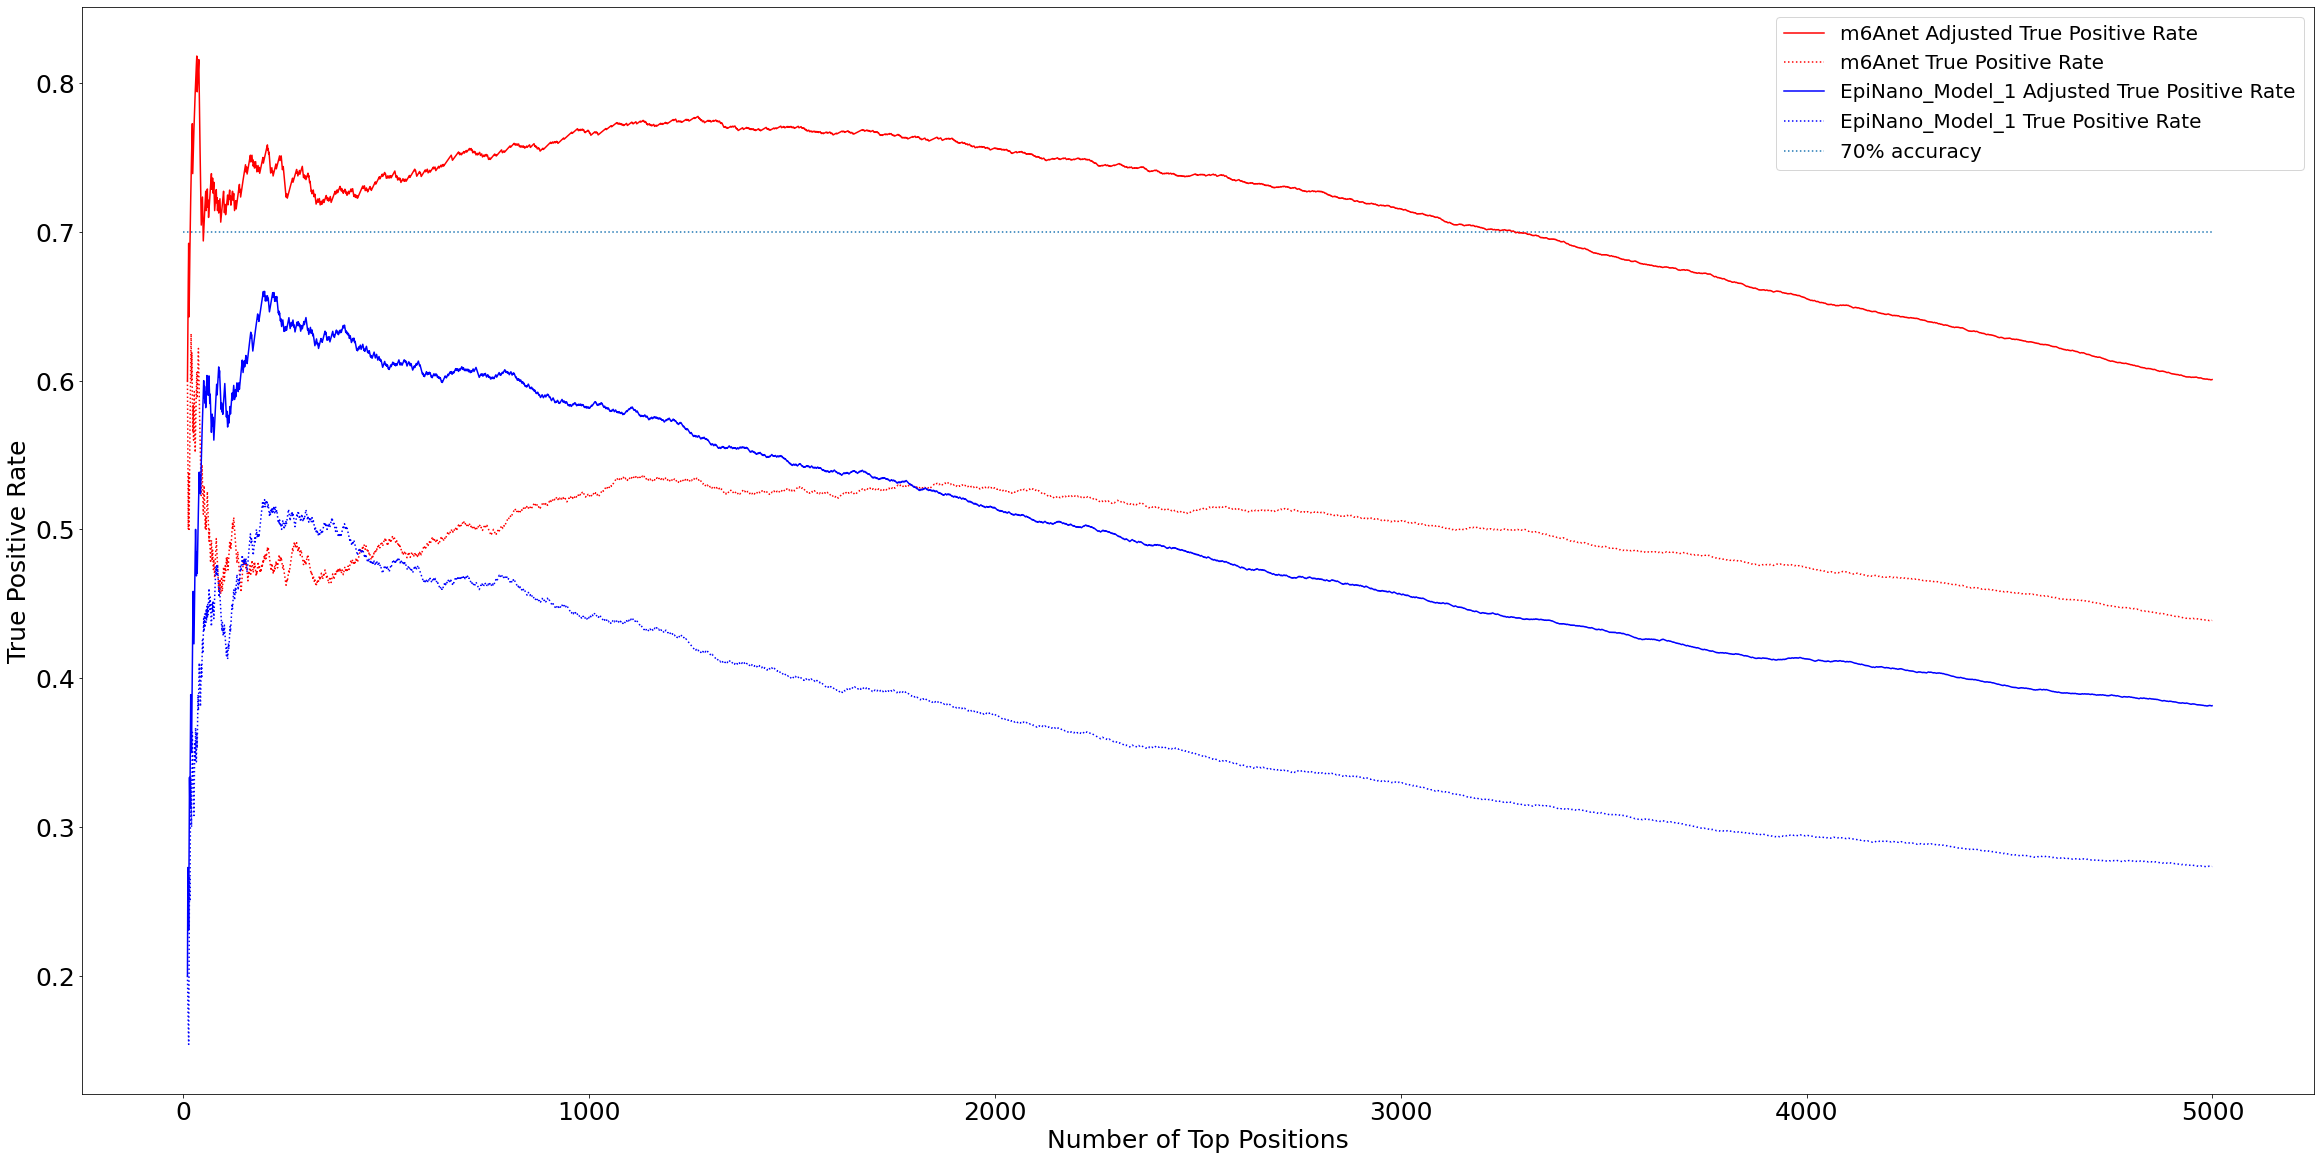

In [66]:
top_n = np.arange(10, 5000)
epinano_df_pval["ko_sens"] = (epinano_df_pval["adjusted_pvalue"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col, color in zip(["m6Anet", "EpiNano_Model_1"], 
                             ["probability_modified_m6Anet",
                              "probability_modified_EpiNano_1"], 
                             ['red', 'blue']):
    to_plot = epinano_df_pval.sort_values(col, ascending=False)
    
    ko_sensitivities = to_plot["ko_sens"].values
    modification_status = to_plot["modification_status"].values
    
    adjusted_tpr = np.array([np.mean((np.logical_or(ko_sensitivities[:n], modification_status[:n]))) for n in top_n])
    tpr = np.array([np.mean((modification_status[:n]))for n in top_n])

    sns.lineplot(x=top_n, y=adjusted_tpr, label=model + " Adjusted True Positive Rate", ax=ax, linestyle="solid", color=color)
    sns.lineplot(x=top_n, y=tpr, label=model + " True Positive Rate", ax=ax, linestyle="dotted", color=color)
    
ax.hlines(0.7, xmin=0, xmax=5000, linestyles="dotted", label="70% accuracy")
plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('True Positive Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})
fig.savefig('m6anet_vs_epinano_adjusted_tpr_best.svg')